# CNN в задаче классификации

## Импорт библиотек

In [86]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [27]:
import sys
import os

In [4]:
# выбор процессора

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Импорт датасета

In [75]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "_datasets")))
from mnist_ds import MNIST_DS

In [76]:
train_data = MNIST_DS(os.path.join(os.getcwd(), "..", "_datasets/mnist/training"))
mnist_test_data = MNIST_DS(os.path.join(os.getcwd(), "..", "_datasets/mnist/testing"))

In [77]:
# Разбиение на выборки
mnist_train_data, mnist_val_data = random_split(train_data, [0.8, 0.2])

In [78]:
# Разбиение на батчи

mnist_train_loader = DataLoader(mnist_train_data, batch_size=16, shuffle=True)
mnist_val_loader = DataLoader(mnist_val_data, batch_size=16, shuffle=False)
mnist_test_loader = DataLoader(mnist_test_data, batch_size=16, shuffle=False)

## Создание модели CNN

In [79]:
class MNIST_Model(nn.Module):
    def __init__(self, in_channels, out):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, (3, 3), bias=False), # (batch_size, in_channels, 28, 28) => (batch_size, 32, 26, 26)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, (3, 3), bias=False),          # (batch_size, 26, 26, 26) => (batch_size, 64, 24, 24)
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.flatten = nn.Flatten()                         # (batch_size, 64, 24, 24) => (batch_size, 64*24*24) 

        self.fc = nn.Sequential(
            nn.Linear(64*24*24, 128),                       # (batch_size, 128) 
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, out)                             # (batch_size, out)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [80]:
# Проверка модели

model_classification = MNIST_Model(1, 10).to(device)
model_classification

MNIST_Model(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Sequential(
    (0): Linear(in_features=36864, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [81]:
# Проверка правильности построения модели

InpCheck = torch.rand([16, 1, 28, 28], dtype=torch.float32).to(device)

OutCheck = model_classification(InpCheck)
OutCheck.shape

torch.Size([16, 10])

## Тренировка модели

In [82]:
# Определяем функцию потерь и оптимизатор градиентного спуска

loss_classification = nn.CrossEntropyLoss()
opt_classification = torch.optim.Adam(model_classification.parameters(), lr=0.001)

In [83]:
mnist_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                            opt_classification,   # оптимизатор
                            mode='min',           # 'max' или 'min'
                            factor=0.1,           # коэффициент, на который будет умножен lr
                            patience=5            # кол-во эпох без улучшения отслеживаемого параметра
                        )

In [84]:
EPOCHS = 60

train_loss = []
val_loss = []
train_acc = []
val_acc = []
mnist_lr_list = []
best_loss = 10000
count = 0
last_saved_mnist_model = ''

for epoch in range(EPOCHS):

    #режим тренировки
    model_classification.train()
    running_train_loss = []
    train_true_answers = 0
    train_loop = tqdm(mnist_train_loader, leave=False)
    for x, targets in train_loop:
        # (batch_size, 28, 28) -> (batch_size, 1, 28, 28)
        x = x.reshape(16, 1, 28, 28).to(device)
        x = x.float()
        targets = targets.reshape(-1).to(torch.int32)
        targets = torch.eye(10)[targets].to(device)


        # прямой проход + расчет ошибки модели
        pred = model_classification(x)
        # pred - ответ модели,  target - правильные ответы -> подаем на вход ф-ции потерь
        loss = loss_classification(pred, targets)

        # обратный проход
        opt_classification.zero_grad() #обнуляем градиенты для каждого батча
        loss.backward() # рассчитываем градиенты для текущего батча

        # шаг оптимизации
        opt_classification.step() # Используем градиенты из шага выше для обновления весов

        running_train_loss.append(loss.item())
        mean_train_loss = sum(running_train_loss)/len(running_train_loss)

        train_true_answers += (targets.argmax(dim=1) == pred.argmax(dim=1)).sum().item()

        train_loop.set_description(f'Epoch: [{epoch+1}/{EPOCHS}], train_loss = {mean_train_loss:.4f}') 

    # Расчет метрик
    train_accuracy = train_true_answers/len(mnist_train_data)
    
    # Сохранение значений функции потерь
    train_loss.append(mean_train_loss)
    train_acc.append(train_accuracy)
    

    #режим оценки
    model_classification.eval()
    with torch.no_grad():
        running_val_loss = []
        val_true_answers = 0
        val_loop = tqdm(mnist_val_loader, leave=False)
        for x, targets in val_loop:
            # (batch_size, 28, 28) -> (batch_size, 1, 28, 28)
            x = x.reshape(16, 1, 28, 28).to(device)
            x = x.float()
            targets = targets.reshape(-1).to(torch.int32)
            targets = torch.eye(10)[targets].to(device)

            # прямой проход + расчет ошибки модели
            pred = model_classification(x)
            # pred - ответ модели,  target - правильные ответы -> подаем на вход ф-ции потерь
            loss = loss_classification(pred, targets)


            running_val_loss.append(loss.item())
            mean_val_loss = sum(running_val_loss)/len(running_val_loss)

            val_loop.set_description(f'Epoch: [{epoch+1}/{EPOCHS}], train_loss = {mean_val_loss:.4f}') 

            val_true_answers += (pred.argmax(dim=1) == targets.argmax(dim=1)).sum().item()

        # Расчет метрик
        val_accuracy = val_true_answers / len(mnist_val_data)
        
    # Сохранение значений функции потерь
    val_loss.append(mean_val_loss)
    val_acc.append(val_accuracy)

    mnist_lr_scheduler.step(mean_val_loss)
    lr = mnist_lr_scheduler.get_last_lr()[0]
    mnist_lr_list.append(lr)
        

    print(f'Epoch: [{epoch+1}/{EPOCHS}], train_loss = {mean_train_loss:.4f}, train_acc={train_accuracy:.4f}, val_loss={mean_val_loss:.4f}, val_acc={val_accuracy:.4f}')

    if mean_val_loss < best_loss:
        best_loss = mean_val_loss
        count = 0

        checkpoint = {
                        'class_to_index': train_data.class_to_index,
                        'state_model': model_classification.state_dict(),     # веса модели
                        'state_opt': opt_classification.state_dict(),             # состояние оптимизатора
                        'state_lr_scheduler': mnist_lr_scheduler.state_dict(),  # состояние scheduler
                        'loss': {                                  # метрики потерь
                            'train_loss': train_loss,
                            'val_loss': val_loss,
                            'best_loss': best_loss
                        },
                        'metric': {                                # метрики accuracy
                            'train_acc': train_acc,
                            'val_acc': val_acc,
                        },
                        'lr': mnist_lr_list,                         # история learning rate
                        'epoch': {                                 # информация об эпохах
                            'EPOCHS': EPOCHS,
                            'save_epoch': epoch
                        }
                    }

        if os.path.exists(last_saved_mnist_model):
            os.remove(last_saved_mnist_model)
        last_saved_mnist_model = f'models/mnist_model_checkpoint_epoch_{epoch+1}.pt'
        torch.save(checkpoint, last_saved_mnist_model)
        print(f'На эпохе = {epoch+1} сохранена модель {last_saved_mnist_model}. Функция потерь на валидации: {mean_val_loss:.4f}', end='\n\n')
    
    if count >= 10:
        print(f'\033[31mОбучение остановлено на {epoch + 1} эпохе.\033[0m')
        break

    count += 1

Epoch: [1/60], train_loss = 0.3881, train_acc=0.8763, val_loss=0.0721, val_acc=0.9784
На эпохе = 1 сохранена модель models/mnist_model_checkpoint_epoch_1.pt. Функция потерь на валидации: 0.0721



Epoch: [2/60], train_loss = 0.1775, train_acc=0.9429, val_loss=0.0737, val_acc=0.9796


Epoch: [3/60], train_loss = 0.1329, train_acc=0.9588, val_loss=0.0427, val_acc=0.9868
На эпохе = 3 сохранена модель models/mnist_model_checkpoint_epoch_3.pt. Функция потерь на валидации: 0.0427



Epoch: [4/60], train_loss = 0.0958, train_acc=0.9705, val_loss=0.0419, val_acc=0.9878
На эпохе = 4 сохранена модель models/mnist_model_checkpoint_epoch_4.pt. Функция потерь на валидации: 0.0419



Epoch: [6/60], train_loss = 0.0605, train_acc=0.9808, val_loss=0.0449, val_acc=0.9882


Epoch: [7/60], train_loss = 0.0475:  21%|█████████                                  | 632/3000 [00:21<01:20, 29.38it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

                                                                                                                       

Epoch: [8/60], train_loss = 0.0429, train_acc=0.9871, val_loss=0.0419, val_acc=0.9901


Epoch: [9/60], train_loss = 0.0368:  66%|███████████████████████████▌              | 1969/3000 [01:12<00:38, 26.46it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

                                                                                                                       

Epoch: [10/60], train_loss = 0.0323, train_acc=0.9894, val_loss=0.0585, val_acc=0.9880


Epoch: [11/60], train_loss = 0.0322:  54%|██████████████████████                   | 1613/3000 [01:09<01:03, 21.77it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch: [11/60], train_loss = 0.0452:  51%|██████████████████████▏                    | 386/750 [00:10<00:11, 31.68it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch: [13/60], train_loss = 0.0262:  96%|███████████████████████████████████████▍ | 2889/3000 [01:40<00:04, 26.61it/s]IOPub m

Epoch: [15/60], train_loss = 0.0123, train_acc=0.9959, val_loss=0.0524, val_acc=0.9910


Epoch: [16/60], train_loss = 0.0115:  22%|█████████▏                                | 656/3000 [00:23<01:21, 28.60it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

                                                                                                                       

Epoch: [17/60], train_loss = 0.0102, train_acc=0.9970, val_loss=0.0549, val_acc=0.9913
Обучение остановлено на 17 эпохе.


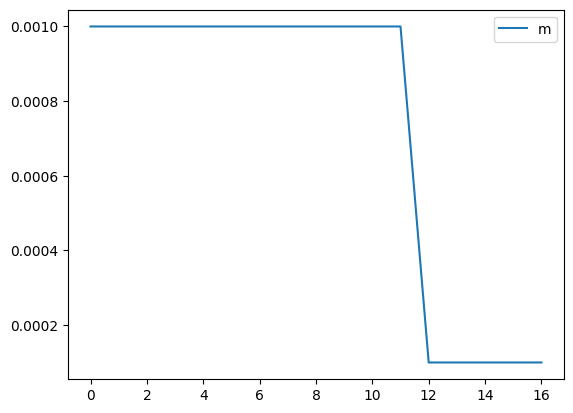

In [87]:
plt.plot(mnist_lr_list)
plt.legend('mnist_lr_list')
plt.show()

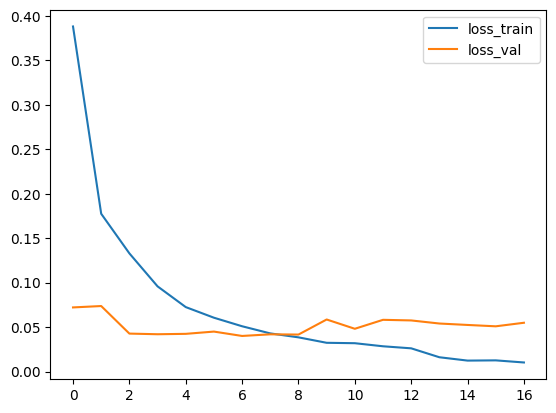

In [88]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['loss_train', 'loss_val'])
plt.show()

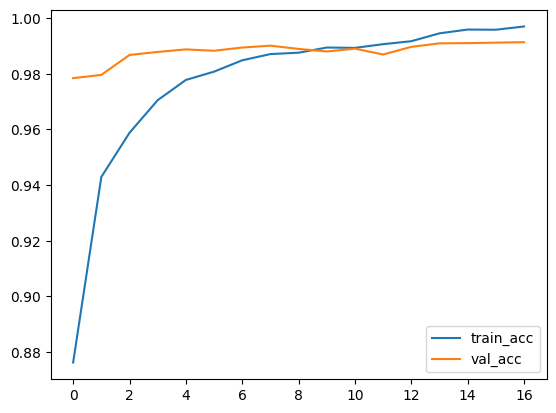

In [89]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['train_acc', 'val_acc'])
plt.show()

## Проверка качества модели на тестовых данных

In [91]:
model_classification.eval()
with torch.no_grad():
        running_test_loss = []
        test_true_answers = 0
        for x, targets in mnist_test_loader:
            # (batch_size, 28, 28) -> (batch_size, 1, 28, 28)
            x = x.reshape(16, 1, 28, 28).to(device)
            x = x.float()
            targets = targets.reshape(-1).to(torch.int32)
            targets = torch.eye(10)[targets].to(device)

            # прямой проход + расчет ошибки модели
            pred = model_classification(x)
            loss = loss_classification(pred, targets)

            running_test_loss.append(loss.item())
            mean_test_loss = sum(running_test_loss)/len(running_test_loss)
            
            test_true_answers += (pred.argmax(dim=1) == targets.argmax(dim=1)).sum().item()

        # Расчет метрик
        running_test_acc = test_true_answers / len(mnist_test_data)

print(f'test_loss = {mean_test_loss:.4f}, test_acc={running_test_acc:.4f}', end = '\n\n')

test_loss = 0.0467, test_acc=0.9911



## Вывод

**Результаты обучения модели CNN MNIST_Model:**

✅ **Модель успешно обучена за 17 эпох** (из 60 запланированных) с применением ранней остановки.

📊 **Метрики качества:**
- **Точность на тестовой выборке:** 99.11% (`test_acc=0.9911`)
- **Ошибка на тестовой выборке:** 0.0467 (`test_loss=0.0467`)

🛠 **Параметры обучения:**
- **Архитектура:** Сверточная нейронная сеть (PyTorch), состоящая из трех блоков (сверточный, flatten, полносвязный) с использованием BatchNorm, ReLU и Dropout
- **Функция потерь:** `CrossEntropyLoss`
- **Оптимизатор:** Adam с начальным learning rate 0.001
- **Планировщик LR:** `ReduceLROnPlateau` (уменьшает LR в 10 раз при отсутствии улучшений 5 эпох)
- **Ранняя остановка:** сработала на 10-й эпохе без значительных улучшений
  
💾 **Лучшая модель сохранена на 46-й эпохе** с учетом:
- Весов модели и оптимизатора
- Гиперпараметров и истории learning rate
- Метрик обучения и валидации

**Вывод:** Модель достигла высокой точности классификации (>99%) на MNIST с эффективным использованием регуляризации через раннюю остановку и адаптивную настройку learning rate.